#### AB Testing Process

- Understanding business problem & data
Given that the app users are primarily socially avoidant individuals, we recognize the importance of maximizing their participation rates. By incorporating different message types, we aim to influence their emotional state positively and create a more engaging and encouraging sign-up process. To achieve this goal, we decided to use experimentation to find out the optimal lay-out of the page by carefully crafting the messaging and event types presented on the sign-up page.

- The control group will serve as a baseline against which the effects of the two treatment groups can be compared. Treatment 1 focuses on promoting positive emotions, while Treatment 2 emphasizes the avoidance of negative emotions. These strategies are intended to make the sign-up experience more appealing and increase participation rates among socially avoidant individuals.

- Assumptions & Hypothesis Testing
    - Check Normality & Homogeneity  (Shapiro, Levene Test)
    - Apply tests (ANOVA, Mann Whitney U Test w/ Bonferroni Corrections)


#### Step 0: Import Library & Data

In [210]:
# import libraries
import itertools
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Hypothesis Testing
from scipy.stats import shapiro
import statsmodels.api as sm
from statsmodels.formula.api import ols
from statsmodels.stats.multicomp import pairwise_tukeyhsd

# Configurations
import os
import random 
from datetime import datetime, timedelta
import warnings
warnings.filterwarnings('ignore')

In [211]:
data = pd.read_csv('message_testing_ab.csv')
data.head()

,UserID,LoggedInFlag,Group,Signup,Date
0,2,1,1,0,4/4/2022
1,3,1,1,0,4/3/2022
2,4,0,3,1,4/8/2022
3,5,0,2,0,4/2/2022
4,6,1,3,1,4/3/2022


#### Step 1: Clean Data

In [213]:
# as people can visit the page multiple times, first count how many visits total vs users assigned to each group sep
data.groupby('Group')['UserID'].count()

Group
1    456
2    502
3    472
Name: UserID, dtype: int64

In [216]:
data.groupby('Group')['UserID'].nunique()

Group
1    225
2    246
3    228
Name: UserID, dtype: int64

#### Step 2: Descriptive Statistics

##### 2-1. Sign-up Rate across Group 

In [217]:
# Number of units across groups
data['Group'].value_counts()

Group
2    502
3    472
1    456
Name: count, dtype: int64

<Axes: xlabel='Group', ylabel='Signup'>

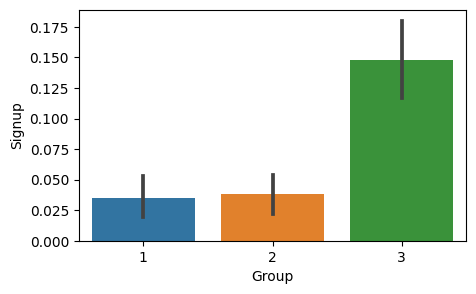

In [218]:
# Sign-up rate across Group 
temp = data.groupby('Group')['Signup'].mean()
plt.figure(figsize = (5, 3))
sns.barplot(x = data['Group'], y = data['Signup'])

##### 2-2. Sign-up Rate across Time

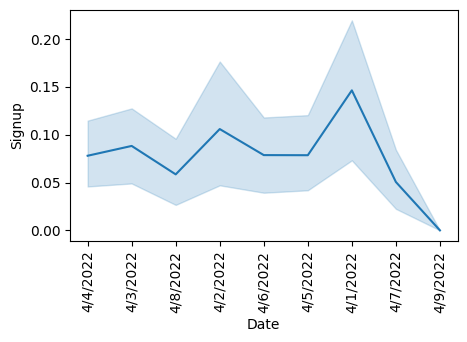

In [219]:
data.groupby(['Date'])['Signup'].mean()

plt.figure(figsize = (5, 3))
sns.lineplot(x = data['Date'], y = data['Signup'])
plt.xticks(rotation = 90)
plt.show()

Group 1


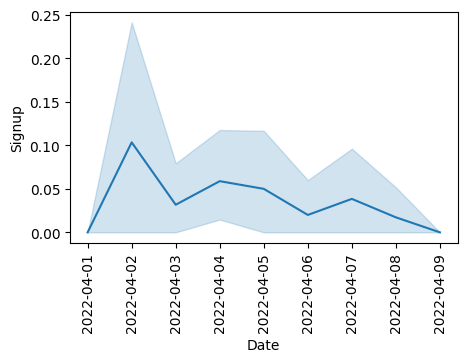

Group 3


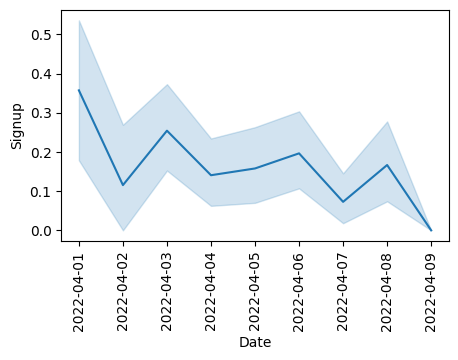

Group 2


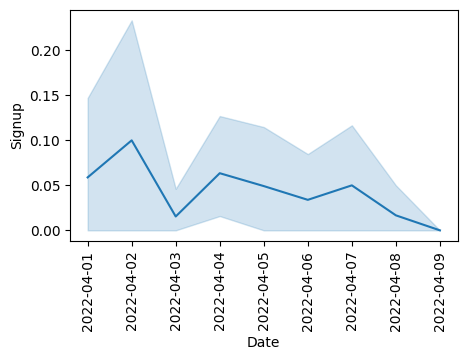

In [192]:
data.groupby(['Group','Date'])['Signup'].mean().reset_index()

for i in data['Group'].unique():
    gdf = data[data['Group'] == i]
    gdf.sort_values('Date', inplace = True)
    print('Group', i)
    plt.figure(figsize = (5, 3))
    sns.lineplot(x = gdf['Date'], y = gdf['Signup'])
    plt.xticks(rotation = 90)
    plt.show()

##### 2-3. Sign-up Rate Weekends vs Weekdays

In [116]:
data['Date'] = pd.to_datetime(data['Date'])
data['Weekend'] = data['Date'].apply(lambda x: 1 if x.weekday() >= 5 else 0)

In [117]:
data.groupby(['Group', 'Weekend'])['Signup'].mean().reset_index()

,Group,Weekend,Signup
0,1,0,0.067901
1,1,1,0.079365
2,2,0,0.082873
3,2,1,0.061538
4,3,0,0.307692
5,3,1,0.305085


Overall, there was no consistent weekly pattern across the week overall. Unlike other metrics such as click through rates, there was no primary effect possibly because sign-up rates depends on more on other factors. Although we expected that people would sign up more on weekends compared to weekdays, it did not seem to be the case.

#### Step 3: Assumption Checking

##### 3-1. Normality

To check the normality assumption for a two-way ANOVA, normality tests is necessary for each group. Shapiro-Wilk Test:

In [221]:
control_group = data.loc[(data['Group'] == 1), 'Signup']
treatment_A = data.loc[(data['Group'] == 2), 'Signup']
treatment_B =  data.loc[(data['Group'] == 3), 'Signup']

In [223]:
import scipy.stats as stats
# Perform Shapiro-Wilk normality test for each group
_, control_pvalue = stats.shapiro(control_group)
_, treatment_a_pvalue = stats.shapiro(treatment_A)
_, treatment_b_pvalue = stats.shapiro(treatment_B)

# Print the p-values
print("Control Group p-value:", control_pvalue)
print("Treatment A Group p-value:", treatment_a_pvalue)
print("Treatment B Group p-value:", treatment_b_pvalue)

Control Group p-value: 1.897386146665089e-40
Treatment A Group p-value: 7.649688316749176e-42
Treatment B Group p-value: 3.5501547277988054e-36


H0 is rejected because the p-value is <0.05. The assumption of normality was not provided. Therefore, we will use the Mann-Whitney U test.

##### 3-2. Heterogeneity

In [226]:
# Perform Levene's test for heterogeneity
statistic, p_value = stats.levene(control_group, treatment_A, treatment_B)

# Print the test statistic and p-value
print("Levene's test statistic:", statistic)
print("p-value:", p_value)

Levene's test statistic: 30.210789085898096
p-value: 1.411856264903064e-13


#### Step 4: Hypothesis Testing


In [235]:
# Perform two-way ANOVA
model = ols('Signup ~ Group', data = data).fit()
anova_table = sm.stats.anova_lm(model, typ=2)
print(anova_table)

             sum_sq      df          F        PR(>F)
Group      3.007584     1.0  45.552712  2.153896e-11
Residual  94.282626  1428.0        NaN           NaN


In [233]:
# Perform Mann-Whitney U test
statistic, p_value = stats.kruskal(control_group, treatment_A, treatment_B)

# Print the test statistic and p-value
print("Mann-Whitney U statistic:", statistic)
print("p-value:", p_value)

Mann-Whitney U statistic: 58.04839493697639
p-value: 2.482854088081856e-13


In [239]:
# Perform pairwise Mann-Whitney U test with Bonferroni adjustment
group_names = data['Group'].unique()
pairwise_results = []

for i in range(len(group_names)):
    for j in range(i+1, len(group_names)):
        group1 = data[data['Group'] == group_names[i]]['Signup']
        group2 = data[data['Group'] == group_names[j]]['Signup']
        statistic, p_value = stats.mannwhitneyu(group1, group2, alternative='two-sided')
        adjusted_p_value = p_value * len(group_names) * (len(group_names) - 1) / 2
        pairwise_results.append((group_names[i], group_names[j], statistic, p_value, adjusted_p_value))

# Print the pairwise comparison results
for result in pairwise_results:
    group1, group2, statistic, p_value, adjusted_p_value = result
    print(f"{group1} vs {group2}: Mann-Whitney U statistic = {statistic}, p-value = {p_value}, adjusted p-value = {adjusted_p_value}")

1 vs 3: Mann-Whitney U statistic = 95432.0, p-value = 2.8037856876280934e-09, adjusted p-value = 8.41135706288428e-09
1 vs 2: Mann-Whitney U statistic = 114140.0, p-value = 0.8204276770999099, adjusted p-value = 2.46128303129973
3 vs 2: Mann-Whitney U statistic = 131558.0, p-value = 2.2913415828457438e-09, adjusted p-value = 6.874024748537232e-09


- Shapiro Testing rejected H0 for Normality assumption. Therefore we needed to apply a Non-parametric test as called Mann Whitney U to compare two groups. As a result, Mann Whitney U Testing rejected H0 hypothesis that the three groups have no difference. Furthermore, through pairwise comparison, 

- Briefly, There are statistically significant difference between Control vs Treatment1 group and Treatment1 and Treatment2 group. In other words, the negative avoidance message group was more effective in inducing participants to sign up. 

In [ ]:
# Guardrail Test
model = ols('Distance ~ Group', data = data).fit()
anova_table = sm.stats.anova_lm(model, typ = 2)
print(anova_table)

Based on the information provided, it seems that the negative avoidance message tested in the study was found to be more effective than the control group or the positive emotion group. This suggests that the negative avoidance message had a positive impact on the sign-up rate. However, due to the lack of users in this experiment, we had to use the whole cohort of participants in this test and results to be applied to the next cohort of users.